## 数据预处理

In [1]:
import pandas as pd
import numpy as np

In [ ]:
sample = pd.read_csv("sample_final.csv",low_memory=False, encoding = 'gbk')
predict = pd.read_csv("predict_final.csv",low_memory=False,encoding = 'gbk')

In [3]:
X = sample.drop(['Unnamed: 0','A股股票代码_A_StkCd','日期_Date','月收益率_Monret',
                 '营收增长率_t-6','营收增长率_t-5','营收增长率_t-4','营收增长率_t-3',
                 '营收增长率_t-2','营收增长率_t-1'], axis=1)
y = sample[['月收益率_Monret']]

In [4]:
X_pre = predict.drop(['Unnamed: 0','A股股票代码_A_StkCd','日期_Date','月收益率_Monret',
                 '营收增长率_t-6','营收增长率_t-5','营收增长率_t-4','营收增长率_t-3',
                 '营收增长率_t-2','营收增长率_t-1'], axis=1)

In [5]:
X = X.drop(columns = X.select_dtypes(include = ['object','datetime64[ns]']).columns)
X_pre = X_pre.drop(columns = X_pre.select_dtypes(include = ['object','datetime64[ns]']).columns)

## 标准化

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
scaler = StandardScaler().fit(X_train)
scaler

StandardScaler()

In [9]:
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_pre_std = scaler.transform(X_pre)

## Light GBM

In [10]:
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM模型
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=lgb_model,
                           param_grid=param_grid,
                           cv=kf,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

In [12]:
# 运行网格搜索
grid_search.fit(X_train_std, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56021
[LightGBM] [Info] Number of data points in the train set: 180703, number of used features: 222
[LightGBM] [Info] Start training from score 0.011243


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [-1, 10, 20], 'n_estimators': [100, 200],
                         'num_leaves': [31, 50]},
             scoring='neg_mean_squared_error', verbose=2)

In [13]:
print("Best parameters found: ", grid_search.best_params_)
print("Best CV score (MSE): ", -grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}
Best CV score (MSE):  0.013780356869749138


In [14]:
print('In-sample R-sq: '+ str(grid_search.best_estimator_.score(X_train_std,y_train)))
print('Out-of-sample R-sq: '+ str(grid_search.best_estimator_.score(X_test_std,y_test)))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In-sample R-sq: 0.46387665911099507
Out-of-sample R-sq: 0.3338007242711204


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [15]:
best_lgbm = grid_search.best_estimator_
predict['LGBM预测收益率']=best_lgbm.predict(X_pre_std)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [16]:
predict.head(5)

,Unnamed: 0.1,Unnamed: 0,A股股票代码_A_StkCd,日期_Date,月收益率_Monret,收盘价(元)_ClPr_t-6,成交量(股)_Trdvol_t-6,每股收益(摊薄)(元/股)_EPS_t-6,净资产收益率(摊薄)(%)_ROE_t-6,每股营业利润(元/股)_OpPrfPS_t-6,...,同比变动下限（%）,同比变动上限（%）,每股收益下限（元）,每股收益上限（元）,是否预盈,授予数量（万股）,授予比例（%）,授予价格（元）,有效期（月）,LGBM预测收益率
0,0,0,2,2021/1/29,-0.0317,26.84,3134507547,0.11,0.6622,0.50,...,-191.0,-171.0,0.067756,0.0754,0.0,2031.165905,2.135389,15.231395,55.931100,-0.049579
1,1,1,2,2021/2/26,0.1911,27.27,1750949854,1.08,6.3939,2.73,...,-191.0,-171.0,0.067756,0.0754,0.0,2052.212933,2.124312,15.043820,55.750730,-0.013315
2,2,2,2,2021/3/31,-0.0937,28.02,1584586872,1.08,6.3939,2.73,...,-191.0,-171.0,0.067756,0.0754,0.0,1944.124607,2.059586,15.976841,55.770599,0.012552
3,3,3,2,2021/4/30,-0.0610,27.55,1065960195,1.71,9.8003,4.33,...,-191.0,-171.0,0.067756,0.0754,0.0,1993.336970,2.078867,15.888000,55.983886,-0.022776
4,4,4,2,2021/5/31,-0.0522,30.70,1553054356,1.71,9.8003,4.33,...,-191.0,-171.0,0.067756,0.0754,0.0,2011.456196,2.074798,15.727755,55.926923,-0.048547


In [17]:
best_model = grid_search.best_estimator_
# 获取特征名称和重要性
feature_names = X_train.columns
importances = best_model.booster_.feature_importance(importance_type='gain')  # 可改为 'split'
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

top10 = importance_df.sort_values(by='importance', ascending=False).head(20)
print(top10)

                   feature   importance
221                 有效期（月）  1371.934421
219                授予比例（%）   898.233674
220                授予价格（元）   806.116665
218               授予数量（万股）   684.058550
210               滞后天数_t-1   526.095433
215              每股收益下限（元）   321.380559
217                   是否预盈   227.661771
191             收盘价波动率_t-1   181.919645
213              同比变动下限（%）   174.367802
211              净利润下限（万元）   170.242026
182     成交金额(元)_Trdsum_t-1   149.823129
216              每股收益上限（元）   148.764831
156             收盘价波动率_t-2   139.401142
175               滞后天数_t-2   136.532394
178  每股收益(摊薄)(元/股)_EPS_t-1   134.552249
35                滞后天数_t-6   133.109363
212              净利润上限（万元）   131.573272
214              同比变动上限（%）   130.415711
70                滞后天数_t-5   125.560771
140               滞后天数_t-3   123.232663


## CNN

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Ridge
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [20]:
X_train_np = X_train_std.astype(np.float32)
X_test_np = X_test_std.astype(np.float32)
X_train_cnn = X_train_np.reshape(-1, 1, X_train_np.shape[1])
X_test_cnn = X_test_np.reshape(-1, 1, X_test_np.shape[1])
y_train_np = y_train.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

In [24]:
class CNNRegressorModule(nn.Module):
    def __init__(self, num_features=20, num_filters=8):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_filters * num_features, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.hardswish(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# 构建 Skorch 模型
cnn = NeuralNetRegressor(
    module=CNNRegressorModule,
    module__num_features=X_train_np.shape[1],
    max_epochs=10,
    lr=0.01,
    batch_size=32,
    optimizer=torch.optim.Adam,
    callbacks=[EarlyStopping(patience=3)],
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=0
)
param_dist_cnn = {
    'lr': [0.01, 0.001],
    'max_epochs': [10, 20],
    'batch_size': [8, 16],
    'module__num_filters': [8, 16],
}

# 随机搜索 
random_search_cnn = RandomizedSearchCV(
    cnn,
    param_distributions=param_dist_cnn,
    n_iter=6,
    cv=3,
    scoring='r2',
    n_jobs=1,
    verbose=1
)

print(f"Using device: {cnn.device}")

random_search_cnn.fit(X_train_cnn, y_train_np)

best_cnn = random_search_cnn.best_estimator_

Using device: cuda
Fitting 3 folds for each of 6 candidates, totalling 18 fits


## EN

In [25]:
param_grid_enet = {
    'alpha': [0.1, 1.0],
    'l1_ratio': [0.3, 0.7],
}
enet = ElasticNet(random_state=42)
grid_enet = GridSearchCV(enet, param_grid_enet, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_enet.fit(X_train_std, y_train)
best_enet = grid_enet.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


## Stacking（Ridge）

In [26]:
# 拼接预测结果作为次级输入
y_train_stack = np.hstack([
    best_cnn.predict(X_train_cnn).reshape(-1, 1).astype(np.float64),
    best_lgbm.predict(X_train_std).reshape(-1, 1),
    best_enet.predict(X_train_std).reshape(-1, 1)
])
y_test_stack = np.hstack([
    best_cnn.predict(X_test_cnn).reshape(-1, 1).astype(np.float64),
    best_lgbm.predict(X_test_std).reshape(-1, 1),
    best_enet.predict(X_test_std).reshape(-1, 1)
])



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [27]:
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0],
}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_ridge.fit(y_train_stack, y_train_np)
best_ridge = grid_ridge.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [28]:
print("Best parameters found: ", grid_ridge.best_params_)
print("Best CV score (MSE): ", -grid_ridge.best_score_)

Best parameters found:  {'alpha': 1.0}
Best CV score (MSE):  -0.480095643084424


In [29]:
print('In-sample R-sq: '+ str(grid_ridge.best_estimator_.score(y_train_stack,y_train_np)))
print('Out-of-sample R-sq: '+ str(grid_ridge.best_estimator_.score(y_test_stack,y_test_np)))

In-sample R-sq: 0.4823051536127154
Out-of-sample R-sq: 0.33038899774805197


## Predict

In [118]:
# 预处理 X_pre_std（CNN 输入需要 3D）
X_pre_np = X_pre_std.astype(np.float32)
X_pre_cnn = X_pre_np.reshape(-1, 1, X_pre_np.shape[1])

y_pre_cnn = best_cnn.predict(X_pre_cnn).reshape(-1, 1)
y_pre_lgb = best_lgbm.predict(X_pre_np).reshape(-1, 1)
y_pre_enet = best_enet.predict(X_pre_np).reshape(-1, 1)

X_pre_stack = np.hstack([y_pre_cnn, y_pre_lgb, y_pre_enet])

predict['Stacking预测收益率'] = best_ridge.predict(X_pre_stack)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [119]:
predict['日期_Date'] = pd.to_datetime(predict['日期_Date'])
predict['year_month'] = predict['日期_Date'].dt.to_period('M')

# 分组后对每组取预测收益率最高的前20条记录
top20_each_month = (
    predict.sort_values(by='LGBM预测收益率', ascending=False)
      .groupby('year_month')
      .head(20)
)

# 再按年月分组，计算这20条记录的实际收益率平均值
avg_actual_return_by_month = (
    top20_each_month.groupby('year_month')['月收益率_Monret']
    .mean()
    .reset_index()
)
avg_actual_return_by_month.rename(columns={'月收益率_Monret': '月收益率_LGBM'}, inplace=True)

avg_actual_return_by_month['year_month'] = avg_actual_return_by_month['year_month'].astype(str)


In [120]:
predict['日期_Date'] = pd.to_datetime(predict['日期_Date'])
predict['year_month'] = predict['日期_Date'].dt.to_period('M')

# 对每组取预测收益率最高的前20条记录
top20_each_month = (
    predict.sort_values(by='Stacking预测收益率', ascending=False)
      .groupby('year_month')
      .head(20)
)

# 再按年月分组，计算这20条记录的实际收益率平均值
avg_actual_return_by_month_1 = (
    top20_each_month.groupby('year_month')['月收益率_Monret']
    .mean()
    .reset_index()
)
avg_actual_return_by_month_1.rename(columns={'月收益率_Monret': '月收益率_Stacking'}, inplace=True)
avg_actual_return_by_month_1['year_month'] = avg_actual_return_by_month_1['year_month'].astype(str)

In [121]:
y_pre_cnn = best_cnn.predict(X_pre_cnn).reshape(-1)
y_pre_enet = best_enet.predict(X_pre_std).reshape(-1)

predict['CNN预测收益率'] = y_pre_cnn
predict['ElasticNet预测收益率'] = y_pre_enet

In [122]:
predict.to_csv('个股预测收益率.csv', encoding = 'utf-8-sig', index = False)

In [123]:
top20_cnn = (
    predict.sort_values(by='CNN预测收益率', ascending=False)
      .groupby('year_month')
      .head(20)
)
avg_return_cnn = (
    top20_cnn.groupby('year_month')['月收益率_Monret']
      .mean()
      .reset_index()
)
avg_return_cnn.rename(columns={'月收益率_Monret': '月收益率_CNN'}, inplace=True)
avg_return_cnn['year_month'] = avg_return_cnn['year_month'].astype(str)

top20_enet = (
    predict.sort_values(by='ElasticNet预测收益率', ascending=False)
      .groupby('year_month')
      .head(20)
)
avg_return_enet = (
    top20_enet.groupby('year_month')['月收益率_Monret']
      .mean()
      .reset_index()
)
avg_return_enet.rename(columns={'月收益率_Monret': '月收益率_ENet'}, inplace=True)
avg_return_enet['year_month'] = avg_return_enet['year_month'].astype(str)

result = result.merge(avg_return_cnn, on='year_month', how='left')
result = result.merge(avg_return_enet, on='year_month', how='left')

In [124]:
result.to_csv('pre_result1.csv', index = False, encoding = 'utf-8-sig')

In [125]:
avg_actual_return_by_month = pd.merge(avg_actual_return_by_month, avg_actual_return_by_month_1, on = 'year_month', how = 'outer')

In [126]:
FF5 = pd.read_csv("fivefactor_monthly.csv",low_memory=False)

In [127]:
hs300 = pd.read_csv("沪深300指数.csv", encoding = 'gbk',low_memory=False)

In [128]:
FF5['year_month'] =FF5['trdmn'].astype(str).str[:4] + '-' + FF5['trdmn'].astype(str).str[4:]

In [129]:
result = avg_actual_return_by_month.merge(FF5[['year_month','mkt_rf','smb','hml','rmw','cma','rf']],
                                          on = 'year_month', how = 'left' )

In [130]:
hs300['交易日期_TrdDt'] = pd.to_datetime(hs300['交易日期_TrdDt'])

hs300['year_month'] = hs300['交易日期_TrdDt'].dt.to_period('M')
result['year_month'] = result['year_month'].astype(str)
hs300['year_month'] = hs300['year_month'].astype(str)

In [131]:
result = result.merge(hs300[['year_month','沪深300收益率']],on = 'year_month', how = 'left' )

In [132]:
result.head(5)

,year_month,月收益率_LGBM,月收益率_Stacking,mkt_rf,smb,hml,rmw,cma,rf,沪深300收益率
0,2021-01,-0.042810,-0.042810,-0.001189,-0.093146,-0.038033,0.094741,-0.074237,0.001241,0.026994
1,2021-02,0.114795,0.114795,0.000278,0.034076,0.055073,-0.036115,0.048722,0.001241,-0.002841
2,2021-03,0.090990,0.090990,-0.029726,0.058863,0.047072,-0.039253,0.060831,0.001241,-0.054040
3,2021-04,0.162520,0.155555,0.025440,-0.020204,-0.015811,0.023727,-0.022577,0.001241,0.014882
4,2021-05,0.138435,0.138435,0.047564,0.028344,-0.009801,-0.021243,0.001530,0.001241,0.040613


In [133]:
# 计算超额收益
result['excess_return'] = result['月收益率_LGBM'] - result['rf']
mean_excess = result['excess_return'].mean()
std_excess = result['excess_return'].std()

# 计算年化 Sharpe Ratio
sharpe_ratio = (mean_excess / std_excess) * np.sqrt(12)

print("LGBM下，年化 Sharpe 比率为：", sharpe_ratio)

LGBM下，年化 Sharpe 比率为： 1.7271127855348443


In [134]:
# 计算超额收益
result['excess_return'] = result['月收益率_Stacking'] - result['rf']
mean_excess = result['excess_return'].mean()
std_excess = result['excess_return'].std()

# 计算年化 Sharpe Ratio
sharpe_ratio = (mean_excess / std_excess) * np.sqrt(12)

print("Stacking下，年化 Sharpe 比率为：", sharpe_ratio)

Stacking下，年化 Sharpe 比率为： 1.7102579462706973


In [135]:
#  计算超额收益
result['excess_return'] = result['沪深300收益率'] - result['rf']

mean_excess = result['excess_return'].mean()
std_excess = result['excess_return'].std()

# 计算年化 Sharpe Ratio
sharpe_ratio = (mean_excess / std_excess) * np.sqrt(12)

print("沪深300指数的年化 Sharpe 比率为：", sharpe_ratio)

沪深300指数的年化 Sharpe 比率为： -0.36164811722389795


In [136]:
import statsmodels.api as sm

# 构造因变量：超额收益
result['excess_return'] = result['月收益率_LGBM'] - result['rf']

# 构造自变量矩阵
X = result[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
X = sm.add_constant(X)

# 拟合回归模型
model = sm.OLS(result['excess_return'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     13.57
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           6.82e-08
Time:                        20:03:08   Log-Likelihood:                 71.580
No. Observations:                  48   AIC:                            -131.2
Df Residuals:                      42   BIC:                            -119.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0382      0.009      4.311      0.0

In [137]:
import statsmodels.api as sm

# 构造因变量：超额收益
result['excess_return'] = result['月收益率_Stacking'] - result['rf']

# 构造自变量矩阵
X = result[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
X = sm.add_constant(X)

model = sm.OLS(result['excess_return'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     14.42
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           3.18e-08
Time:                        20:03:08   Log-Likelihood:                 73.927
No. Observations:                  48   AIC:                            -135.9
Df Residuals:                      42   BIC:                            -124.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0366      0.008      4.336      0.0

In [138]:
import statsmodels.api as sm

result['excess_return'] = result['沪深300收益率'] - result['rf']

X = result[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']]
X = sm.add_constant(X)

model = sm.OLS(result['excess_return'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     108.2
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           7.26e-23
Time:                        20:03:08   Log-Likelihood:                 135.15
No. Observations:                  48   AIC:                            -258.3
Df Residuals:                      42   BIC:                            -247.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.099      0.2

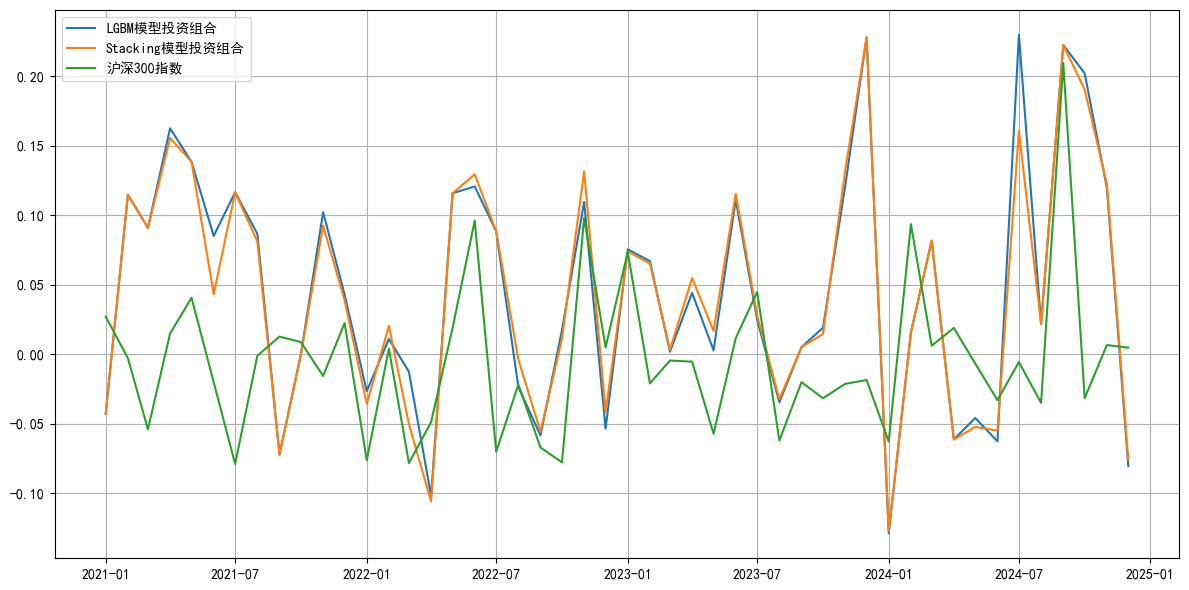

In [139]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

result = result.sort_values(by='year_month')

result['year_month'] = pd.to_datetime(result['year_month'])

plt.figure(figsize=(12, 6))
plt.plot(result['year_month'], result['月收益率_LGBM'], label='LGBM模型投资组合')
plt.plot(result['year_month'], result['月收益率_Stacking'], label='Stacking模型投资组合')
plt.plot(result['year_month'], result['沪深300收益率'], label='沪深300指数')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("月收益率走势对比图.png", dpi = 400)
plt.show()

In [140]:
result['累计收益_LGBM'] = (1 + result['月收益率_LGBM']).cumprod()
result['累计收益_Stacking'] = (1 + result['月收益率_Stacking']).cumprod()
result['累计收益_沪深300'] = (1 + result['沪深300收益率']).cumprod()

In [141]:
result.to_csv('pre_result2.csv', encoding = 'utf-8-sig',index = False) 

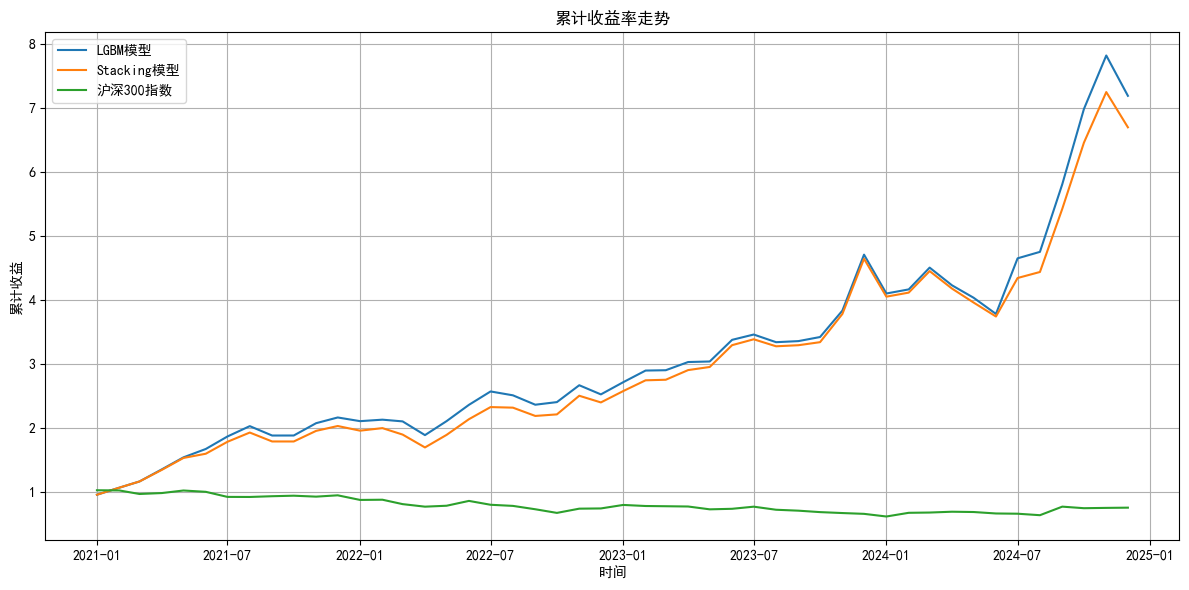

In [142]:
# 按时间排序
result = result.sort_values(by='year_month')
result['year_month'] = pd.to_datetime(result['year_month'])

# 计算累计收益率（累乘）
result['累计收益_LGBM'] = (1 + result['月收益率_LGBM']).cumprod()
result['累计收益_Stacking'] = (1 + result['月收益率_Stacking']).cumprod()
result['累计收益_沪深300'] = (1 + result['沪深300收益率']).cumprod()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(result['year_month'], result['累计收益_LGBM'], label='LGBM模型')
plt.plot(result['year_month'], result['累计收益_Stacking'], label='Stacking模型')
plt.plot(result['year_month'], result['累计收益_沪深300'], label='沪深300指数')
plt.title("累计收益率走势")
plt.ylabel("累计收益")
plt.xlabel("时间")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("累计收益率走势对比图.png", dpi=400)
plt.show()

In [143]:
def print_metrics(name, model, X_train, y_train, X_test, y_test, model_type='sklearn'):
    if model_type == 'cnn':  # CNN 特殊处理
        y_train_pred = model.predict(X_train).reshape(-1)
        y_test_pred = model.predict(X_test).reshape(-1)
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    print(f"【{name}】模型表现：")
    print(" - In-sample R²:", r2_score(y_train, y_train_pred))
    print(" - In-sample MSE:", mean_squared_error(y_train, y_train_pred))
    print(" - Out-of-sample R²:", r2_score(y_test, y_test_pred))
    print(" - Out-of-sample MSE:", mean_squared_error(y_test, y_test_pred))
    print()

print_metrics("LGBM", best_lgbm, X_train_std, y_train, X_test_std, y_test)
print_metrics("ElasticNet", best_enet, X_train_std, y_train, X_test_std, y_test)
print_metrics("CNN", best_cnn, X_train_cnn, y_train_np, X_test_cnn, y_test_np, model_type='cnn')
print_metrics("Stacking", best_ridge, y_train_stack, y_train_np, y_test_stack, y_test_np)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


【LGBM】模型表现：
 - In-sample R²: 0.46387665911099507
 - In-sample MSE: 0.010924550580444108
 - Out-of-sample R²: 0.3338007242711204
 - Out-of-sample MSE: 0.013757524091666569

【ElasticNet】模型表现：
 - In-sample R²: 0.0
 - In-sample MSE: 0.020376935207351562
 - Out-of-sample R²: -6.106962505247893e-06
 - Out-of-sample MSE: 0.020650890220945305

【CNN】模型表现：
 - In-sample R²: 0.010484158992767334
 - In-sample MSE: 0.02016330137848854
 - Out-of-sample R²: 0.004095852375030518
 - Out-of-sample MSE: 0.0205661803483963

【Stacking】模型表现：
 - In-sample R²: 0.4823051536127154
 - In-sample MSE: 0.010549034344874628
 - Out-of-sample R²: 0.33038899774805197
 - Out-of-sample MSE: 0.013827978835991014

